#### Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime as dt

2023-08-04 13:50:17.649769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Definition of model training hyperparameters

In [2]:
EPOCHS = 10
BATCH_SIZE = 32

#### Modeling data fetching

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

In [4]:
__max_value = train_x.max().astype(np.float32)

# Data normalization
train_x, test_x = train_x/__max_value, test_x/__max_value

In [5]:
CLASS_NAMES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

##### Make tensorflow dataset

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(train_x.shape[0]).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(BATCH_SIZE)

2023-08-04 13:50:23.027730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22787 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:5e:00.0, compute capability: 7.5
2023-08-04 13:50:23.028655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22295 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:af:00.0, compute capability: 7.5


#### Check data

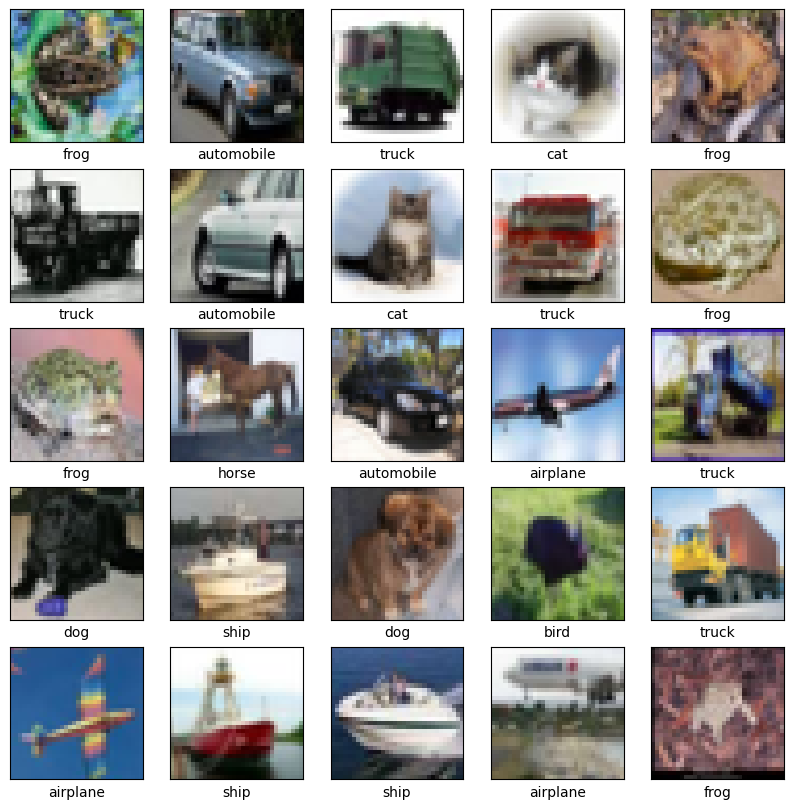

In [7]:
plt.figure(figsize=(10, 10))

for idx in range(25):
    plt.subplot(5, 5, idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[idx+200])
    plt.xlabel(CLASS_NAMES[train_y[idx+200][0]])
    
plt.show()

#### Model

##### Define

In [8]:
kargs = {
    'model_name'    : 'Cifar10CnnClassifier',
    'input_filter'  : 128,
    'conv_filter'   : 256,
    'full_units'    : 512,
    'output_dims'   : 10,
}

In [9]:
class Cifar10CnnClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(Cifar10CnnClassifier, self).__init__(name=kargs['model_name'])
        
        # (3,3) --> 3, input_shape=train_images[0].shape
        # If you add the input shape, immediately run 'model.summary()'
        self._input     = tf.keras.layers.Conv2D(
                              kargs['input_filter'], 
                              (3, 3), 
                              activation='relu', 
                              input_shape=train_x[0].shape
                          )
        # MaxPooling2D: (2,2) --> (1,1)
        # Reduces processing time and prevents overfitting
        self._mp2d_1    = tf.keras.layers.MaxPooling2D((2,2))
        self._hidden_1  = tf.keras.layers.Conv2D(kargs['conv_filter'], (3, 3), activation='relu')
        self._mp2d_2    = tf.keras.layers.MaxPooling2D((2,2))
        self._hidden_2  = tf.keras.layers.Conv2D(kargs['conv_filter'], (3, 3), activation='relu')
        self._mp2d_3    = tf.keras.layers.MaxPooling2D((2,2))
        self._flatten   = tf.keras.layers.Flatten()
        self._full_con  = tf.keras.layers.Dense(kargs['full_units'], activation='relu')
        self._output    = tf.keras.layers.Dense(kargs['output_dims'], activation='softmax')
        
    def call(self, input):
        _model = self._input(input)
        _model = self._mp2d_1(_model)
        _model = self._hidden_1(_model)
        _model = self._mp2d_2(_model)
        _model = self._hidden_2(_model)
        _model = self._mp2d_3(_model)
        _model = self._flatten(_model)
        _model = self._full_con(_model)
        _model = self._output(_model)
        return _model

##### Create 

In [10]:
model = Cifar10CnnClassifier(**kargs)

# Define loss, optimizer, accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy()
# TODO: Comparison needed with the value obtained by setting 1e-4.
optimizer = tf.keras.optimizers.Adam(1e-3)  

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

##### Define train and test function

In [11]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        _predictions = model(images, training=True)
        _loss = loss(labels, _predictions)
    _gradients = tape.gradient(_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(_gradients, model.trainable_variables))
    train_loss(_loss)
    train_accuracy(labels, _predictions)

In [12]:
@tf.function
def test_step(images, labels):
    _predictions = model(images, training=False)
    _loss = loss(labels, _predictions)
    test_loss(_loss)
    test_accuracy(labels, _predictions)

##### Define History class

In [13]:
class History:
    
    def __init__(self):
        self.accuracy = []
        self.val_accuracy = []
        self.loss = []
        self.val_loss = []

##### Training

In [14]:
def training():
    _history = History()
    
    for _epoch in range(EPOCHS):
        _dt_epoch_start = dt.now()
        
        train_loss.reset_state()
        train_accuracy.reset_state()
        test_loss.reset_state()
        test_accuracy.reset_state()
        
        for _images, _labels in train_ds:
            train_step(_images, _labels)
            
        for _images, _labels in test_ds:
            test_step(_images, _labels)
            
        _history.accuracy.append(train_accuracy.result().numpy())
        _history.loss.append(train_loss.result().numpy())
        _history.val_accuracy.append(test_accuracy.result().numpy())
        _history.val_loss.append(test_loss.result().numpy())
            
        print(
            f'Epoch: {_epoch+1}, '
            f'Train: loss({train_loss.result():.05f}), '
            f'accuracy({train_accuracy.result():.05f}), '
            f'Test: loss({test_loss.result():.05f}), '
            f'accuracy({test_accuracy.result():.05f}), '
            f'Processing time: {dt.now() - _dt_epoch_start}'
        )
        
    return _history

In [15]:
_dt_training_start = dt.now()

history = training()

print(f'Total processing time: {dt.now() - _dt_training_start}')

2023-08-04 13:50:27.490849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [50000,32,32,3]
	 [[{{node Placeholder/_0}}]]
2023-08-04 13:50:27.491182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [50000,1]
	 [[{{node Placeholder/_1}}]]
2023-08-04 13:50:29.394632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-04 13:50:30.244695: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-04 13:50:30.703481: I tensorflow/co

Epoch: 1, Train: loss(1.46782), accuracy(0.46484), Test: loss(1.17387), accuracy(0.57390), Processing time: 0:00:19.342283
Epoch: 2, Train: loss(1.04447), accuracy(0.63240), Test: loss(1.04355), accuracy(0.63510), Processing time: 0:00:13.263529
Epoch: 3, Train: loss(0.86551), accuracy(0.69530), Test: loss(0.89053), accuracy(0.69110), Processing time: 0:00:13.227913
Epoch: 4, Train: loss(0.74980), accuracy(0.73290), Test: loss(0.84717), accuracy(0.71170), Processing time: 0:00:12.480630
Epoch: 5, Train: loss(0.64908), accuracy(0.77164), Test: loss(0.85981), accuracy(0.71090), Processing time: 0:00:12.519822
Epoch: 6, Train: loss(0.56935), accuracy(0.79934), Test: loss(0.84460), accuracy(0.72240), Processing time: 0:00:13.077405
Epoch: 7, Train: loss(0.49282), accuracy(0.82470), Test: loss(0.86861), accuracy(0.71710), Processing time: 0:00:12.383788
Epoch: 8, Train: loss(0.42367), accuracy(0.84902), Test: loss(0.92032), accuracy(0.72050), Processing time: 0:00:12.608388
Epoch: 9, Train:

##### Evaluation

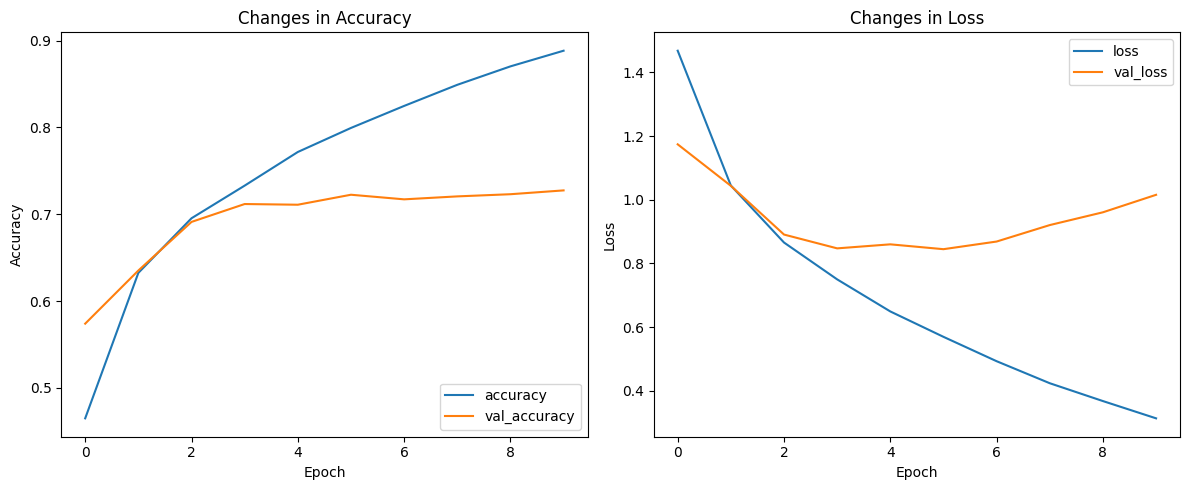

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.title('Changes in Accuracy')
plt.plot(history.accuracy, label='accuracy')
plt.plot(history.val_accuracy, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.title('Changes in Loss')
plt.plot(history.loss, label='loss')
plt.plot(history.val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [21]:
sample_data = np.array([test_x[100]])

In [22]:
prediction = model(sample_data)

##### Service

In [33]:
def service(index):
    # (32,32,3) --> (1,32,32,3)
    _sample_data = np.array([test_x[index]])
    # (1,10) --> (10,)
    _prediction = tf.reshape(model(_sample_data), (10))
    _x_labels = list(range(0, _prediction.numpy().size))
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.imshow(_sample_data[0,:,:,0], aspect='auto')
    plt.title('Sample image to be predicted')
    
    plt.subplot(1,2,2)
    plt.bar(_x_labels, _prediction)
    plt.xlabel('Class index')
    plt.ylabel('Probability')
    plt.title('Probability of being the 10 images')
    
    plt.tight_layout()
    plt.show()
    
    _prediction = tf.math.argmax(_prediction).numpy()
    print(
        f'Label: {CLASS_NAMES[test_y[index][0]]}, '
        f'Predict: {CLASS_NAMES[_prediction]}'
    )

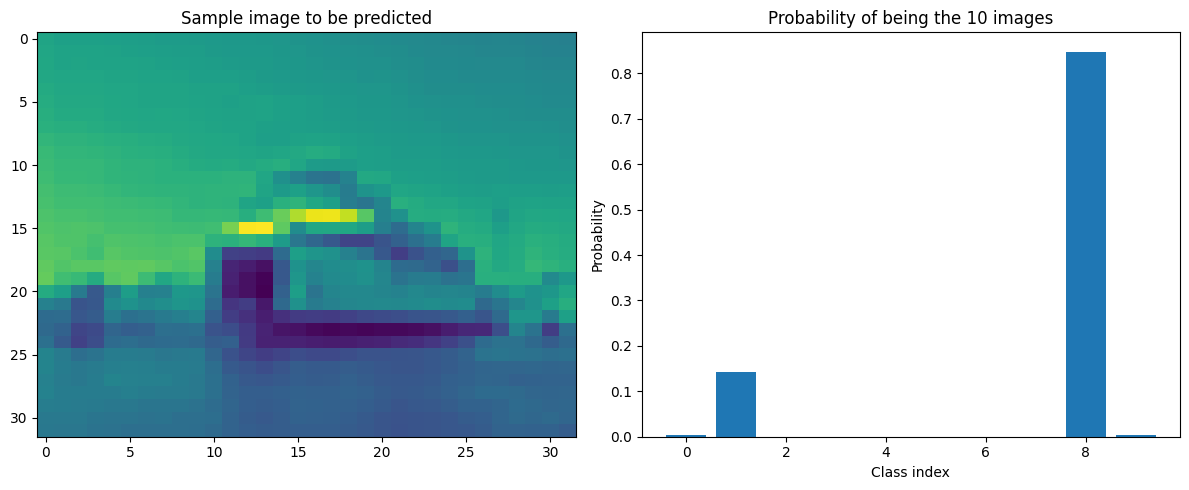

Label: ship, Predict: ship


In [35]:
service(310)

In [28]:
np.squeeze(test_y[100])

array(4, dtype=uint8)

In [29]:
test_y[100][0]

4